In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

In [16]:
def get_frequencencies(wave_data, sampling_frequency):
    n = wave_data.shape[0]
    sample_count = (n/sampling_frequency) # estimated samples
    print(sample_count)
    sp = np.fft.fft(wave_data, n, norm = 'ortho')
    freq = np.fft.fftfreq(n, d = 1/sampling_frequency)
    
    frequencies = pd.DataFrame(freq, columns=['Frequency'])
    frequencies['Amplitude'] = np.abs(sp)/sample_count
    frequencies['Phase'] = np.angle(sp)
    frequencies['Real'] = np.real(sp)
    frequencies['Imaginary'] = np.imag(sp)
    frequencies['wave'] = sp
    frequencies = frequencies[frequencies.Amplitude > 0.1*frequencies.Amplitude.max()] # Greater than 10% of the max amplitude
    frequencies.set_index('Frequency', inplace=True)
    return frequencies

In [17]:
def reconstruct_wave(magnitudes, time):
    omega = np.reshape(2*np.pi*magnitudes.index,(magnitudes.shape[0],1))
    time = np.reshape(time,(1, time.shape[0]))
    return (np.cos((omega @ time)).T @ magnitudes)/2#*np.pi#*(n**0.1)) 
    # Scaling factor needed to make the wave have the same amplitude as the original wave

## Working with Waves

In [ ]:
wave = np.genfromtxt('babes/wave.csv', delimiter=',')
estimated_sampling_frequency = 30 #sampling_frequency; changes the anplitude, not the shape of the curve

n = wave.shape[0]
# n = 4
sample_count = (n/estimated_sampling_frequency) # estimated samples

time_arr = np.linspace(start = 0, stop = sample_count, num = wave.shape[0])

plt.plot(wave)

In [ ]:
# sp = np.fft.fft(wave, n, norm = 'ortho')
# freq = np.fft.fftfreq(n, d = 1/estimated_sampling_frequency)

In [ ]:
# frequencies = pd.DataFrame(freq, columns=['Frequency'])
# frequencies['Amplitude'] = np.abs(sp)/sample_count
# frequencies['Phase'] = np.angle(sp)
# frequencies['Real'] = np.real(sp)
# frequencies['Imaginary'] = np.imag(sp)
# frequencies['wave'] = sp
# frequencies = frequencies[frequencies.Amplitude > 0.1*frequencies.Amplitude.max()] # Greater than 10% of the max amplitude
# frequencies.set_index('Frequency', inplace=True)
# frequencies.head()

In [ ]:
# Create a function to get the frequencies of a wave
frequencies = get_frequencencies(wave, estimated_sampling_frequency)
frequencies.head()

### Wave Reconstruction

In [ ]:
reconstructed_wave = reconstruct_wave(frequencies.Amplitude, time_arr)

plt.figure(figsize= (20,5))
plt.plot(reconstructed_wave, label='Reconstructed Wave')
plt.plot(wave, label='Original Wave')
# plt.plot(np.fft.ifft(frequencies['wave'], n, norm = 'ortho'), label='IFFT Wave') # Inacurate in reduced dimensions
plt.legend(loc = 4)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## FFT Regression

### Reading Data

15.0

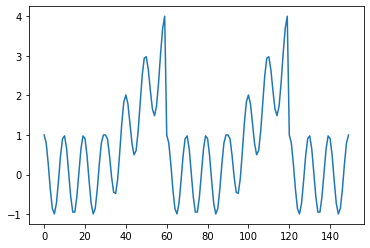

In [18]:
df = pd.read_csv('babes/wave_with_slope.csv')

estimated_sampling_frequency = 10 #sampling_frequency; changes the anplitude, not the shape of the curve

n = df.shape[0]
# n = 4
sample_count = (n/estimated_sampling_frequency) # estimated samples

time_arr = np.linspace(start = 0, stop = sample_count, num = df.shape[0])

plt.plot(df)
sample_count

### Breaking Data into Chunks/Seasonal Cycles

In [19]:
estimated_seasons = 5
season_length = n//estimated_seasons

seasons = {}

for i in range(estimated_seasons):
    seasons['season_'+str(i)] = df['0'].iloc[i*season_length :(i+1)*season_length].reset_index(drop=True)

seasons_df = pd.DataFrame(seasons)
seasons_df.reset_index(inplace=True)
seasons_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,0.796093,0.899541,0.796093,0.899541,0.796093
2,2,0.267528,0.474425,0.267528,0.474425,0.267528
3,3,-0.370138,-0.059793,-0.370138,-0.059793,-0.370138
4,4,-0.856857,-0.443064,-0.856857,-0.443064,-0.856857


<module 'matplotlib.pyplot' from '/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/matplotlib/pyplot.py'>

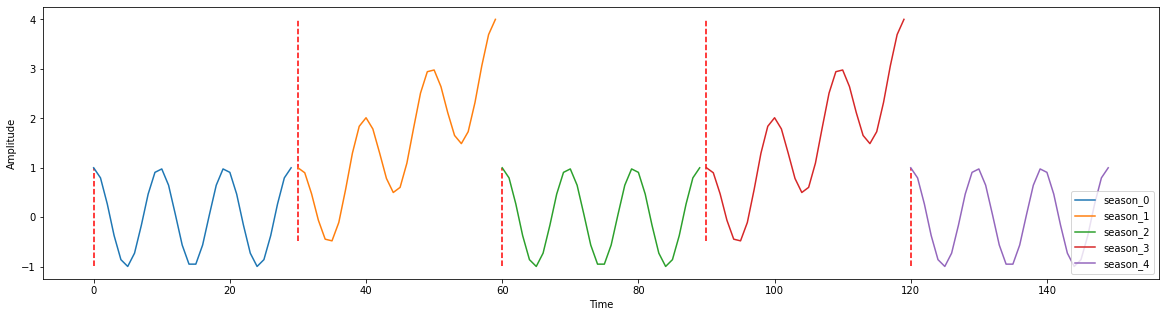

In [20]:
def plot_data(df, title=None):
    plt.figure(figsize= (20,5)) 
    for i, cols in enumerate(df.columns[1:]):
        plt.plot([i*season_length + j for j in range(season_length)], df[cols].values,label=cols)
        plt.vlines(i*season_length, df[cols].min(), df[cols].max(), color='r', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(loc = 4)
    plt.title(title)
    return plt

plot_data(seasons_df)

### Remove Linear Trends in seasonal cycles

In [29]:
residuals_df = {}

models_dict = {}

for cols in seasons_df.columns[1:]:
    y, X = dmatrices(f'{cols} ~ index', data=seasons_df, return_type='dataframe')
    model = sm.OLS(y, X)       # Set up the model
    result = model.fit()       # Fit model (find the intercept and slopes)
    models_dict[cols] = result
    residuals_df[cols] = result.resid # Residuals
    # print(result.params)

residuals_df = pd.DataFrame(residuals_df)
residuals_df.reset_index(inplace=True)

residuals_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,0.966667,0.966667,0.966667,0.966667,0.966667
1,1,0.762760,0.762760,0.762760,0.762760,0.762760
2,2,0.234195,0.234195,0.234195,0.234195,0.234195
3,3,-0.403471,-0.403471,-0.403471,-0.403471,-0.403471
4,4,-0.890191,-0.890191,-0.890191,-0.890191,-0.890191


In [23]:
models_dict

{'season_0': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff3d8d74fd0>,
 'season_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff3d8d74f70>,
 'season_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff40b9bb640>,
 'season_3': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff3d8e59df0>,
 'season_4': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff3e8dbfdf0>}

<module 'matplotlib.pyplot' from '/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/matplotlib/pyplot.py'>

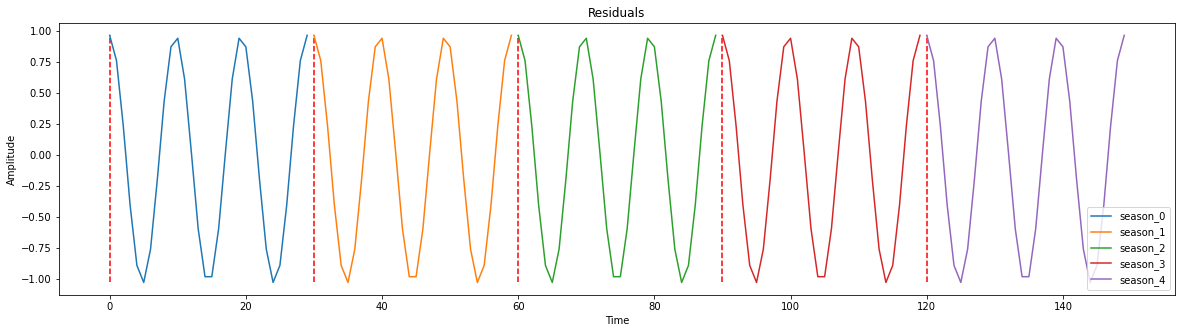

In [24]:
plot_data(residuals_df, title='Residuals')

### Reconstructing the Residual Wave

3.0
3.0
3.0
3.0
3.0


<module 'matplotlib.pyplot' from '/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/matplotlib/pyplot.py'>

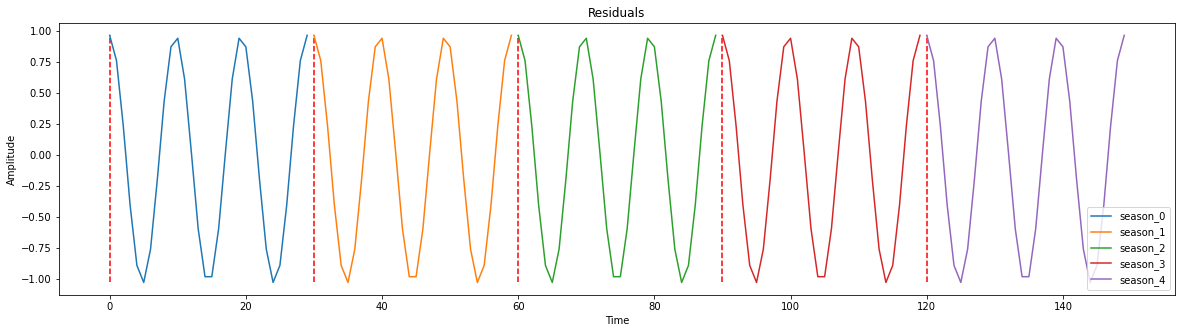

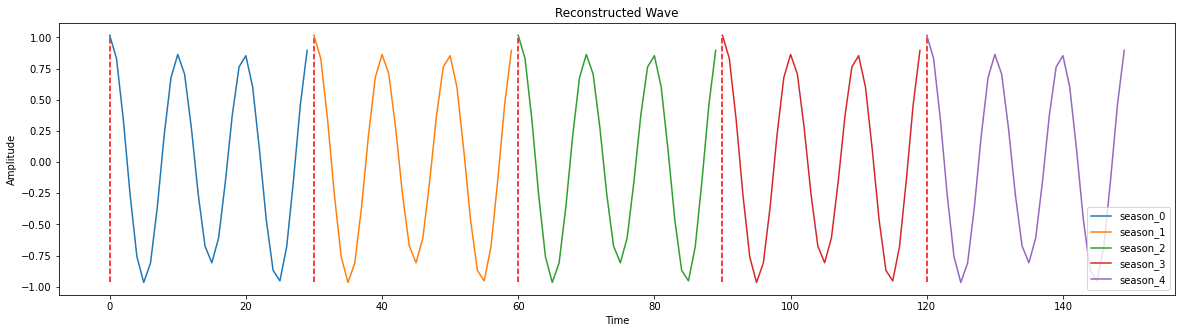

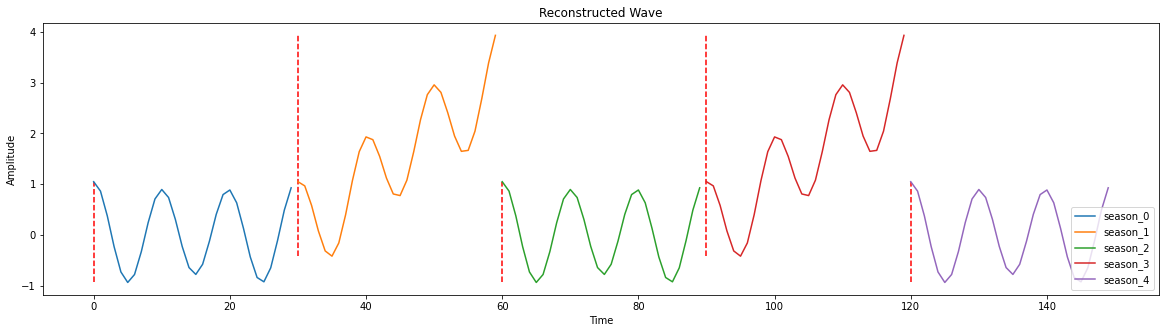

In [25]:
reconstruct = {}
for cols in residuals_df.columns[1:]:
    _ = get_frequencencies(residuals_df.season_0, estimated_sampling_frequency)
    reconstruct[cols] = reconstruct_wave(_.Amplitude, time_arr[:season_length])

reconstruct = pd.DataFrame(reconstruct).reset_index()

plot_data(residuals_df, title = "Residuals")
plot_data(reconstruct, title = "Reconstructed Wave")


# Adding Linear trend to the wave
for cols in reconstruct.columns[1:]:
    _ = pd.DataFrame([1]*season_length, columns=['intercept'])
    _['index'] = reconstruct[cols].index.values
    trend = models_dict[cols].predict(_)
    reconstruct[cols] += trend
    
plot_data(reconstruct, title = "Reconstructed Wave")

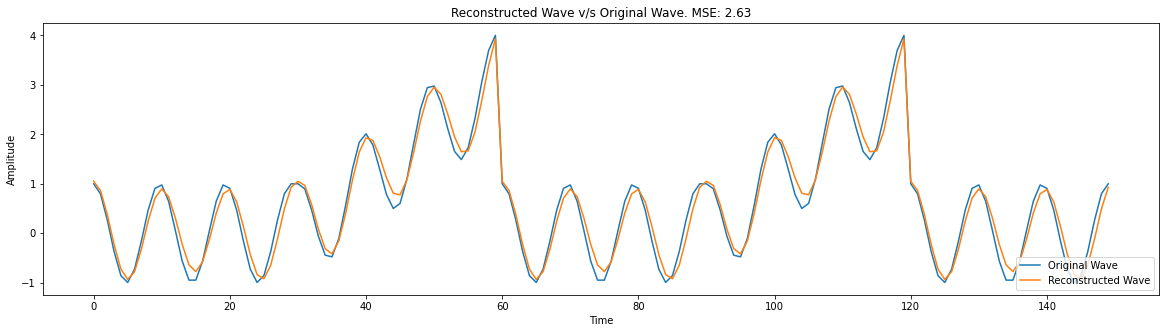

In [27]:
plt.figure(figsize= (20,5))
plt.plot(df.to_numpy(), label='Original Wave')
plt.plot(reconstruct.iloc[:,1:].to_numpy().T.flatten(), label='Reconstructed Wave')
plt.legend(loc = 4)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Wave v/s Original Wave. MSE: '+str(np.round(np.mean((df.to_numpy() - reconstruct.iloc[:,1:].to_numpy().T.flatten())**2),2)))
plt.show()

In [ ]:
plt.savefig('plots/reconstructed_wave.png')

### Fourier Regression of seasonal cycles